https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/download/?format=csv&q=date:%5B2018-12-31T23:00:00Z+TO+2022-10-01T21:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B




https://gmd.copernicus.org/articles/14/1553/2021/

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [260]:
# import wget

# site_url = 'https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/download/?format=csv&q=date:%5B2018-12-31T23:00:00Z+TO+2022-10-01T21:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
# file_name = wget.download(site_url)



In [261]:
#!mv donnees-synop-essentielles-omm.csv data_meteo.csv

In [262]:
df = pd.read_csv('data_meteo.csv',sep=';')
df.head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,7558,2019-11-09T13:00:00+01:00,101380.0,-110.0,8.0,320.0,4.9,278.05,274.35,77.0,...,712,Millau,12145,CC de Millau Grands Causses,241200567.0,Aveyron,12,Occitanie,76.0,11
1,7790,2019-11-09T13:00:00+01:00,100790.0,-60.0,8.0,30.0,3.5,288.55,281.95,65.0,...,10,Lucciana,2B148,CC de Marana-Golo,200036499.0,Haute-Corse,2B,Corse,94.0,11
2,61980,2019-11-09T13:00:00+01:00,101570.0,-130.0,6.0,80.0,4.4,299.65,290.45,57.0,...,8,Sainte-Marie,97418,CA Intercommunale du Nord de la Réunion (CINOR),249740119.0,La Réunion,974,La Réunion,4.0,11
3,61980,2019-11-09T16:00:00+01:00,101710.0,140.0,3.0,90.0,2.8,297.65,290.65,65.0,...,8,Sainte-Marie,97418,CA Intercommunale du Nord de la Réunion (CINOR),249740119.0,La Réunion,974,La Réunion,4.0,11
4,81401,2019-11-09T16:00:00+01:00,101020.0,80.0,8.0,50.0,2.6,306.55,297.75,60.0,...,5,Saint-Laurent-du-Maroni,97311,CC de l'Ouest Guyanais,249730037.0,Guyane,973,Guyane,3.0,11


In [263]:
df.shape

(648685, 82)

In [264]:
df['Date'] = df['Date'].astype('string')

In [265]:
for i in range(df.shape[0]):
    df['Date'][i]=df['Date'][i][0:10]+" "+df['Date'][i][11:19]


In [266]:
df['Date']=pd.to_datetime(df['Date'])


In [267]:
columns = ['Date','region (name)','Température (°C)','Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

In [268]:
df_Date= df[columns]
df_Date.head()

,Date,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2019-11-09 13:00:00,Occitanie,4.9,101380.0,4.9,77.0,92970.0,8.1,-0.1
1,2019-11-09 13:00:00,Corse,15.4,100790.0,3.5,65.0,100650.0,5.5,0.0
2,2019-11-09 13:00:00,La Réunion,26.5,101570.0,4.4,57.0,101420.0,6.0,0.0
3,2019-11-09 16:00:00,La Réunion,24.5,101710.0,2.8,65.0,101560.0,4.8,0.0
4,2019-11-09 16:00:00,Guyane,33.4,101020.0,2.6,60.0,100960.0,NaN,0.0


In [269]:
df_Date = df_Date.dropna()
df_Date.shape

(473732, 9)

In [270]:
df_Date.set_index('Date', inplace = True)
df_Date.head()

,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,,
2019-11-09 13:00:00,Occitanie,4.9,101380.0,4.9,77.0,92970.0,8.1,-0.1
2019-11-09 13:00:00,Corse,15.4,100790.0,3.5,65.0,100650.0,5.5,0.0
2019-11-09 13:00:00,La Réunion,26.5,101570.0,4.4,57.0,101420.0,6.0,0.0
2019-11-09 16:00:00,La Réunion,24.5,101710.0,2.8,65.0,101560.0,4.8,0.0
2019-11-09 19:00:00,Normandie,6.7,100280.0,4.0,96.0,99470.0,6.3,8.9


# GroupBY : 'Date'

In [271]:
df_Date = df_Date.groupby(by=['Date']).mean()

df_Date.head()

,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,
2019-01-01 01:00:00,7.738636,103197.272727,2.679545,85.681818,101559.318182,5.129545,-0.004545
2019-01-01 04:00:00,6.943182,103215.227273,3.020455,85.863636,101567.272727,5.293182,-0.004545
2019-01-01 07:00:00,6.700000,103189.767442,2.883721,86.813953,101510.000000,5.172093,-0.009302
2019-01-01 10:00:00,7.568182,103253.409091,2.627273,84.704545,101605.454545,4.959091,0.011364
2019-01-01 13:00:00,9.095349,103211.162791,3.123256,80.139535,101542.558140,5.753488,-0.004651


In [272]:
df_Date.shape

(10954, 7)

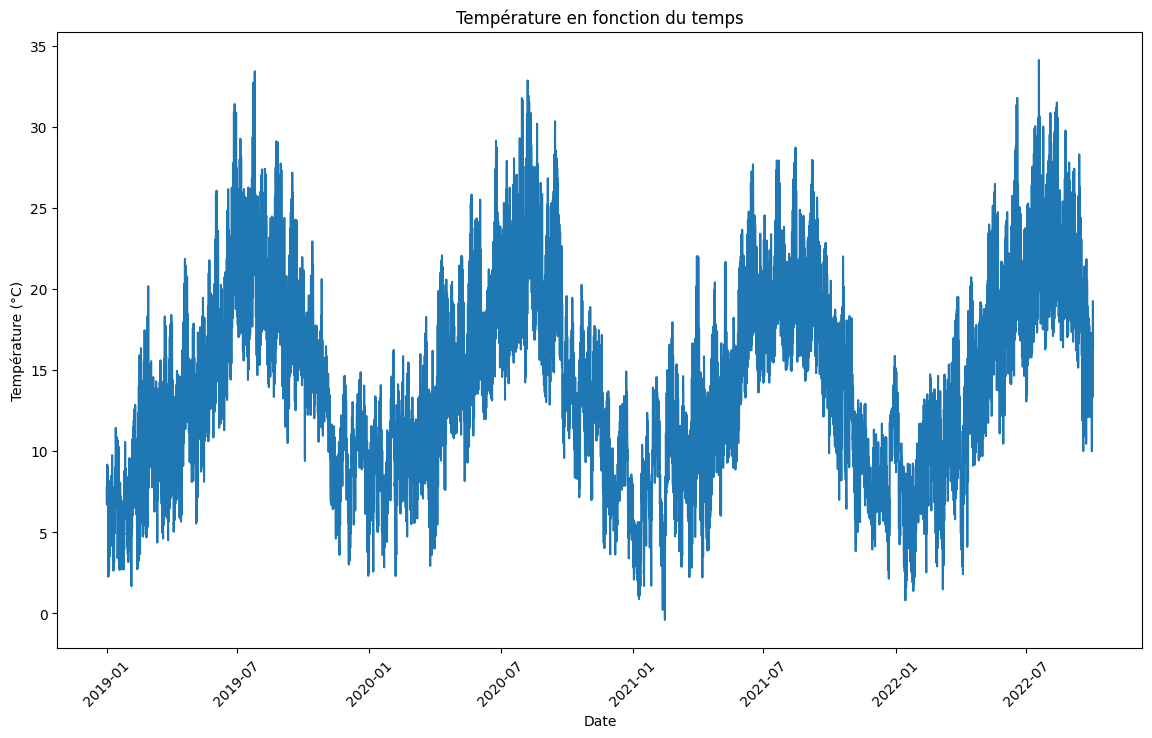

In [273]:
plt.figure(figsize=(14,8))
plt.plot(df_Date.index,df_Date['Température (°C)'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction du temps')
plt.show()

In [274]:
df_region = df[columns]
df_region = df_region.dropna()

# GroupBY : 'Date' & 'Region'

In [275]:
df_region = df_region.groupby(by=['Date','region (name)']).mean()
df_region.head()

Température (°C)  \
Date                region (name)                               
2019-01-01 01:00:00 Auvergne-Rhône-Alpes             6.766667   
                    Bourgogne-Franche-Comté          7.100000   
                    Bretagne                         8.450000   
                    Centre-Val de Loire              7.050000   
                    Corse                            6.300000   

                                             Pression au niveau mer  \
Date                region (name)                                     
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                   103330.0   
                    Bourgogne-Franche-Comté                103480.0   
                    Bretagne                               103760.0   
                    Centre-Val de Loire                    103650.0   
                    Corse                                  102690.0   

                                             Vitesse du vent moyen 10 mn  \
Date                region (name)                                          
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                        4.433333   
                    Bourgogne-Franche-Comté                     2.000000   
                    Bretagne                                    1.700000   
                    Centre-Val de Loire                         1.350000   
                    Corse                                       3.000000   

                                             Humidité  Pression station  \
Date                region (name)                                         
2019-01-01 01:00:00 Auvergne-Rhône-Alpes         88.0          100690.0   
                    Bourgogne-Franche-Comté      93.0          100670.0   
                    Bretagne                     82.0          103025.0   
                    Centre-Val de Loire          90.5          101915.0   
                    Corse                        78.0          102560.0   

                                             Rafales sur une période  \
Date                region (name)                                      
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                    8.333333   
                    Bourgogne-Franche-Comté                 3.700000   
                    Bretagne                                3.850000   
                    Centre-Val de Loire                     4.400000   
                    Corse                                   5.200000   

                                             Précipitations dans les 3 dernières heures  
Date                region (name)                                                        
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                                      -0.033333  
                    Bourgogne-Franche-Comté                                    0.000000  
                    Bretagne                                                   0.000000  
                    Centre-Val de Loire                                        0.000000  
                    Corse                                                      0.000000

In [276]:
df_region = df_region.reset_index(level=['Date','region (name)'])
df_region['region (name)'] = df_region['region (name)'].astype('string')
df_region

,Date,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2019-01-01 01:00:00,Auvergne-Rhône-Alpes,6.766667,103330.0,4.433333,88.0,100690.0,8.333333,-0.033333
1,2019-01-01 01:00:00,Bourgogne-Franche-Comté,7.100000,103480.0,2.000000,93.0,100670.0,3.700000,0.000000
2,2019-01-01 01:00:00,Bretagne,8.450000,103760.0,1.700000,82.0,103025.0,3.850000,0.000000
3,2019-01-01 01:00:00,Centre-Val de Loire,7.050000,103650.0,1.350000,90.5,101915.0,4.400000,0.000000
4,2019-01-01 01:00:00,Corse,6.300000,102690.0,3.000000,78.0,102560.0,5.200000,0.000000
...,...,...,...,...,...,...,...,...,...
192730,2022-10-01 23:00:00,Pays de la Loire,17.400000,102200.0,4.500000,96.0,101890.0,10.000000,-0.100000
192731,2022-10-01 23:00:00,Provence-Alpes-Côte d'Azur,18.500000,102165.0,3.400000,78.5,101820.0,5.200000,0.000000
192732,2022-10-01 23:00:00,Saint-Pierre-et-Miquelon,12.200000,101570.0,8.000000,90.0,101490.0,12.300000,0.000000
192733,2022-10-01 23:00:00,Terres australes et antarctiques françaises,-0.300000,101500.0,3.600000,79.0,101120.0,5.700000,0.000000


## Création sous base de données pour chaque régions

In [277]:
from typing import Counter


regions = []
for region in df_region['region (name)']:
    regions.append(region)
regions = list(Counter(regions).keys())
regions

['Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Corse',
 'Grand Est',
 'Guyane',
 'Hauts-de-France',
 'La Réunion',
 'Martinique',
 'Mayotte',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",
 'Saint-Pierre-et-Miquelon',
 'Île-de-France',
 'Terres australes et antarctiques françaises']

In [278]:
df_region = pd.get_dummies(df_region,columns=['region (name)'],prefix="",prefix_sep='')
df_region

,Date,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,...,Martinique,Mayotte,Normandie,Nouvelle-Aquitaine,Occitanie,Pays de la Loire,Provence-Alpes-Côte d'Azur,Saint-Pierre-et-Miquelon,Terres australes et antarctiques françaises,Île-de-France
0,2019-01-01 01:00:00,6.766667,103330.0,4.433333,88.0,100690.0,8.333333,-0.033333,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,7.100000,103480.0,2.000000,93.0,100670.0,3.700000,0.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 01:00:00,8.450000,103760.0,1.700000,82.0,103025.0,3.850000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 01:00:00,7.050000,103650.0,1.350000,90.5,101915.0,4.400000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 01:00:00,6.300000,102690.0,3.000000,78.0,102560.0,5.200000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192730,2022-10-01 23:00:00,17.400000,102200.0,4.500000,96.0,101890.0,10.000000,-0.100000,0,0,...,0,0,0,0,0,1,0,0,0,0
192731,2022-10-01 23:00:00,18.500000,102165.0,3.400000,78.5,101820.0,5.200000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
192732,2022-10-01 23:00:00,12.200000,101570.0,8.000000,90.0,101490.0,12.300000,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,0
192733,2022-10-01 23:00:00,-0.300000,101500.0,3.600000,79.0,101120.0,5.700000,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,0


In [279]:



columns = ['Date','Température (°C)','Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

AuvergneRhoneAlpes=df_region.loc[df_region[regions[0]]==1].reset_index(drop=True)
AuvergneRhoneAlpes = AuvergneRhoneAlpes[columns]
BourgogneFrancheComte=df_region.loc[df_region[regions[1]]==1].reset_index(drop=True)
BourgogneFrancheComte =BourgogneFrancheComte[columns]
Bretagne = df_region.loc[df_region[regions[2]]==1].reset_index(drop=True)
Bretagne =Bretagne[columns]
CentreValdeLoire= df_region.loc[df_region[regions[3]]==1].reset_index(drop=True)
CentreValdeLoire = CentreValdeLoire[columns]
Corse=df_region.loc[df_region[regions[4]]==1].reset_index(drop=True)
Corse = Corse[columns]
GrandEst=df_region.loc[df_region[regions[5]]==1].reset_index(drop=True)
GrandEst = GrandEst[columns]
Guyane=df_region.loc[df_region[regions[6]]==1].reset_index(drop=True)
Guyane = Guyane[columns]
HautsdeFrance=df_region.loc[df_region[regions[7]]==1].reset_index(drop=True)
HautsdeFrance = HautsdeFrance[columns]
LaReunion=df_region.loc[df_region[regions[8]]==1].reset_index(drop=True)
LaReunion = LaReunion[columns]
Martinique=df_region.loc[df_region[regions[9]]==1].reset_index(drop=True)
Martinique = Martinique[columns]
Mayotte=df_region.loc[df_region[regions[10]]==1].reset_index(drop=True)
Mayotte = Mayotte[columns]
Normandie=df_region.loc[df_region[regions[11]]==1].reset_index(drop=True)
Normandie = Normandie[columns]
NouvelleAquitaine=df_region.loc[df_region[regions[12]]==1].reset_index(drop=True)
NouvelleAquitaine = NouvelleAquitaine[columns]
Occitanie=df_region.loc[df_region[regions[13]]==1].reset_index(drop=True)
Occitanie = Occitanie[columns]
PaysdelaLoire=df_region.loc[df_region[regions[14]]==1].reset_index(drop=True)
PaysdelaLoire = PaysdelaLoire[columns]
ProvenceAlpesCotedAzur=df_region.loc[df_region[regions[15]]==1].reset_index(drop=True)
ProvenceAlpesCotedAzur = ProvenceAlpesCotedAzur[columns]
SaintPierreetMiquelon=df_region.loc[df_region[regions[16]]==1].reset_index(drop=True)
SaintPierreetMiquelon = SaintPierreetMiquelon[columns]
IledeFrance=df_region.loc[df_region[regions[17]]==1].reset_index(drop=True)
IledeFrance = IledeFrance[columns]
Terresaustralesetantarctiquesfrançaises=df_region.loc[df_region[regions[18]]==1].reset_index(drop=True)
Terresaustralesetantarctiquesfrançaises =Terresaustralesetantarctiquesfrançaises[columns]


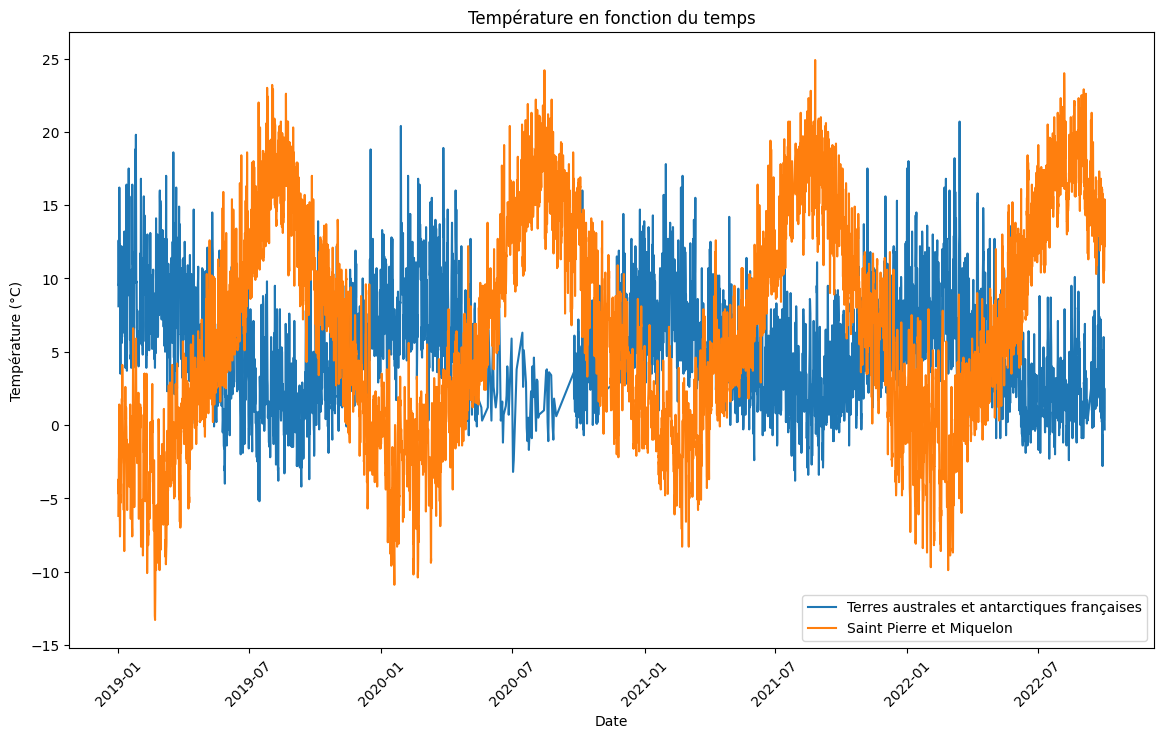

In [280]:
plt.figure(figsize=(14,8))


plt.plot(Terresaustralesetantarctiquesfrançaises['Date'],Terresaustralesetantarctiquesfrançaises['Température (°C)'])
plt.plot(SaintPierreetMiquelon[ 'Date'],SaintPierreetMiquelon['Température (°C)'])



plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction du temps')
plt.legend(['Terres australes et antarctiques françaises','Saint Pierre et Miquelon'])
plt.show()



# Trouver la périodicité

Nous pouvons imaginer une saisonalité de 1 ans soit 365 * 24 / 3 = 2920 car nous avons un relevé de données toutes les 3 heures.

Vérifions ça.

In [281]:
df_temporaire = pd.DataFrame(df_Date.index.astype('string'))
for year in range (df_temporaire.shape[0]):
    df_temporaire['Date'][year] = df_temporaire['Date'][year][0:4]

df_temporaire['Date'].value_counts()


2020    2926
2019    2918
2021    2918
2022    2192
Name: Date, dtype: Int64

On peut aussi imaginer une periodicité journalière. Il y a des observations toutes les trois heures, donc 24 / 3 = 8 on rajoute 1 pour l'obseration qui revient au même point donc 9

# Décomposition STL

In [282]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

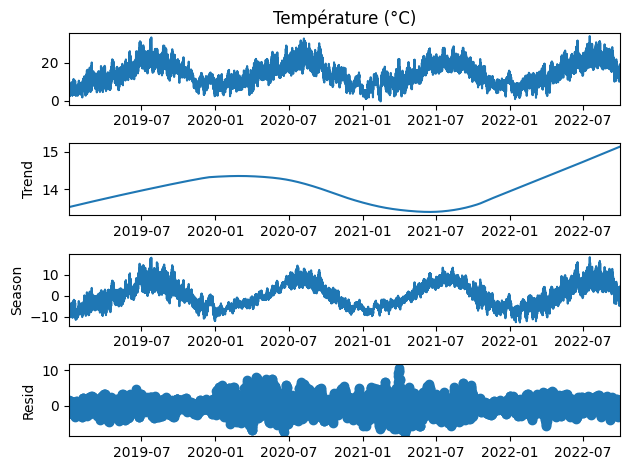

In [283]:
result = STL(df_Date['Température (°C)'], period=2920).fit()

_ = result.plot()

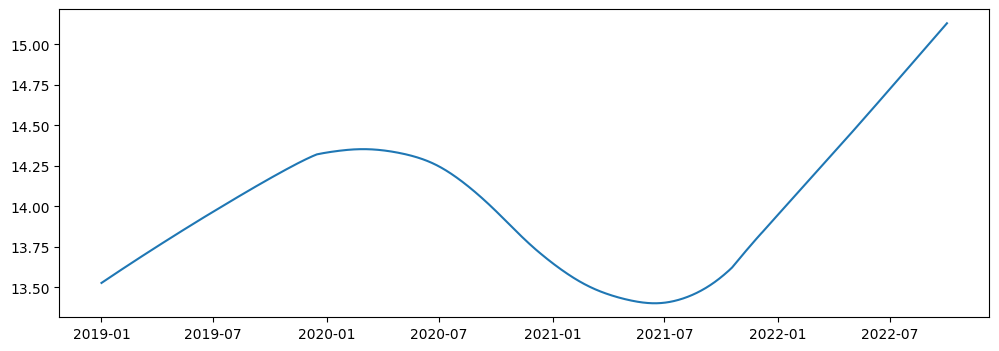

In [284]:
plt.figure(figsize=(12,4))
plt.plot(result.trend)

## Découpe la database en trois train / test / new data

In [285]:
def decoupe_data(data,div):
    data = data.reset_index(drop=True)
    mul = div - 1
    max = data.index.max()
    new_index = data.index.max() -400
    val = max / div 
    train_test_index = int(mul*val)
    return data.iloc[0:train_test_index],data.iloc[train_test_index:new_index],data.iloc[new_index:max]


## NaiveForcaster
### Avec la database sur l'IDF


In [286]:
#from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import smape_loss
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series

def plot_ys(*args, **kwargs):
    # restore previous behaviour (jfb)
    nb_series=len(args)
    plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

8193 2331


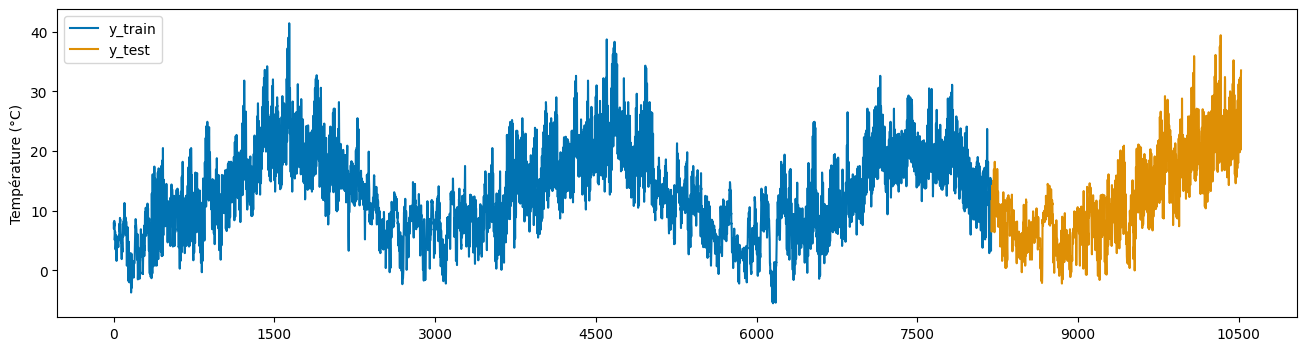

In [287]:
y = pd.Series(data=IledeFrance['Température (°C)']) #index=t[1:],
#y_train, y_test = temporal_train_test_split(y, test_size=2000)
y_train,y_test,new = decoupe_data(IledeFrance['Température (°C)'],4)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [288]:
fh = np.arange(1,len(y_test)+1) 


In [289]:
# Pour limiter le nombre de points, on ne prend que les 200 derniers
y_train = y_train[-4000:]


2890 13331118588099.15
2900 17002006315256.648
2910 11592277033129.826
2920 18547643253007.105
2930 17195210932475.49
la valeur la plus faible en loss correspond à une saisonalité de :  2910


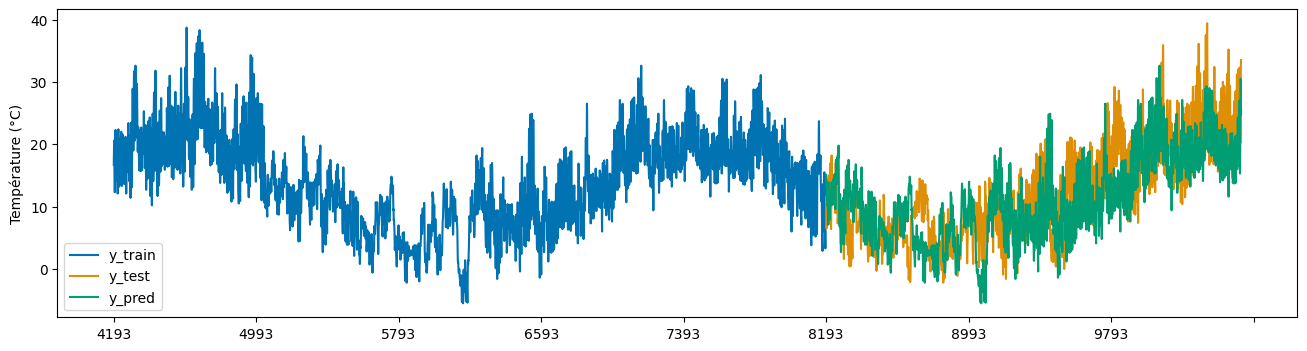

In [290]:
# using sktime 
res = []
val = [2890,2900,2910, 2920,2930]
from sktime.forecasting.naive import NaiveForecaster
for i in val:
    forecaster = NaiveForecaster(strategy="last",sp=i)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    res.append(smape_loss(y_pred, y_test))
    print(i,res[-1])
saisonalite = val[res.index(min(res))]

print("la valeur la plus faible en loss correspond à une saisonalité de : ",saisonalite)

forecaster = NaiveForecaster(strategy="last",sp=saisonalite)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
smape_loss(y_pred, y_test)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);


# #Analyse

## Approches réduction - K Neighboor

0.08939767276640474

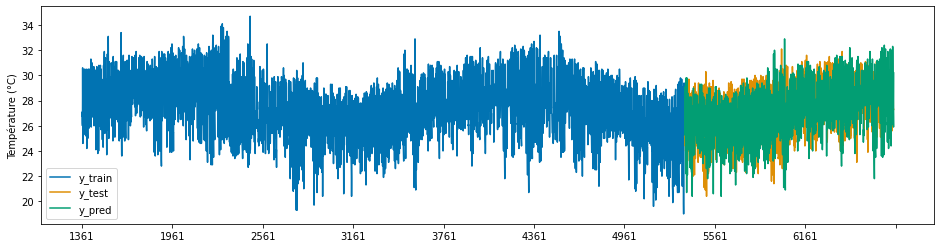

In [138]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(estimator=regressor, 
                                         window_length=10, strategy="direct")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Exponential smoothing

0.0903880227254107

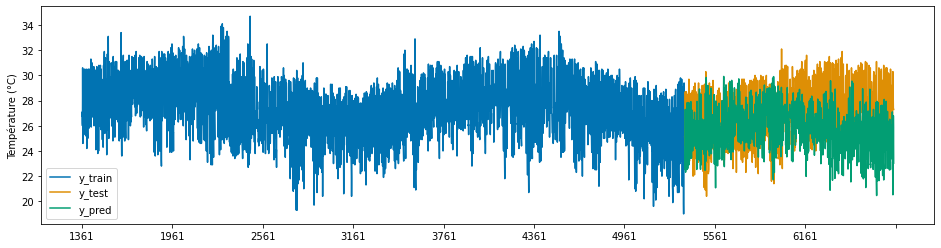

In [139]:

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="add", 
                                  sp=2000)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Sarimax

In [291]:
import warnings
warnings.filterwarnings("ignore")

In [292]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [293]:
perform_adf_test(IledeFrance['Température (°C)'])

ADF Statistic: -4.415856
p-value: 0.000278


On peut voir que la p-value est inférieur a 0.05 on peut donc conclure avec une haute confiance que notre série est stationnaire. On eut supposer que le résultat est la même pour les autres régions.

In [294]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

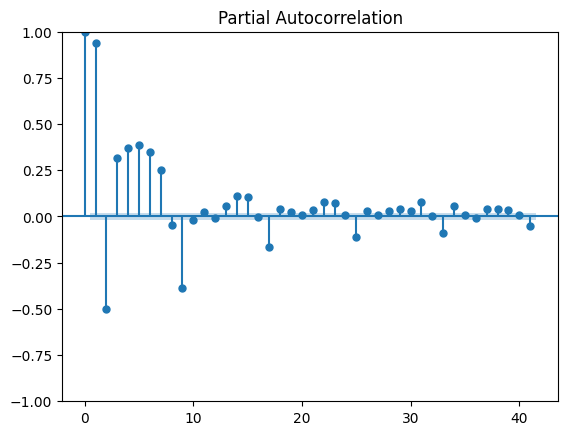

In [295]:
pacf_plot = plot_pacf(IledeFrance['Température (°C)'])

On peut voir qu'il y a beaucoup de point qui on une influence direct sur la mesures à l'instant $t$. On va garder uniquement les 8 premiers points dans notre études pour ne pas faire trop compliquer, de plus 8 mesures correspond à une journée, concrètement la température à de la veille à la même heure est corrélée avec la température actuel. Ce graphique induit un modèl AR(8)

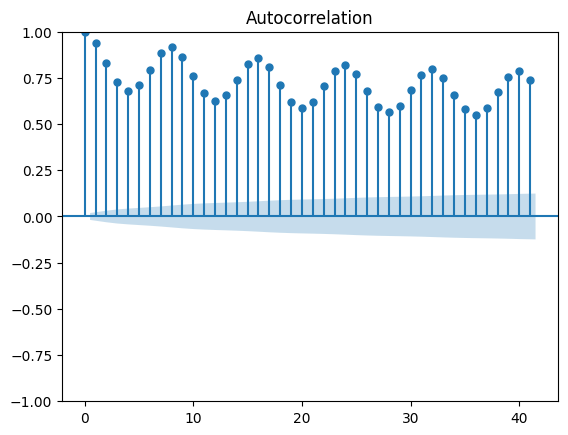

In [296]:
acf_plot = plot_acf(IledeFrance['Température (°C)'])

On peut voir que les 40 mesures qui précèdent une mesures ont une influence sur 

## AR model


In [297]:
from statsmodels.tsa.arima.model import ARIMA


In [298]:
y_train,y_test,new = decoupe_data(IledeFrance['Température (°C)'],5)

In [299]:
# for p in [1,2,3,4,5,6,7,8]:
#     mod_AR = ARIMA(y_train, order=(p,0,0))
#     res = mod_AR.fit()
#     print("p={}, d={}, q={} --> AICc = {}".format(p,0,0, res.aicc))


Le AIC les plus petit est pour les ordre 8 

In [300]:
mod_AR = ARIMA(y_train, order=(8,0,0))
res = mod_AR.fit()


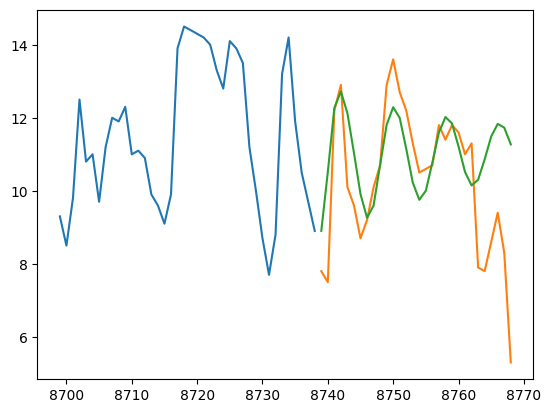

In [301]:
plt.plot(y_train[-40:])
plt.plot(y_test[:30])
plt.plot(res.forecast(30))

Les premières prédictions sont proches de la réalité, mais plus on s'éloigne plus il y a des erreurs, c'est la limite de ces modèles

## ARMA model

On peut compléter le model en utilisant un model "moving average", il n'est pas intéréssant d'ultiliser ce type de model seul car il prédit très vite uniquement la moyenne même si dans notre cas aux vus du plot ACF on pourrait utiliser les erreurs de au moins 40 données précédentes. Par soucis de temps de compilation, on va uniquement tester en utilisant jusqu'à 10 données précédentes.

In [302]:
# for q in [1,2,3,4,8,9,10]:
#     mod_ARMA = ARIMA(y_train, order=(8,0,q))
#     res = mod_ARMA.fit()
#     print("p={}, d={}, q={} --> AICc = {}".format(8,0,q, res.aicc))

On peut voir que le AIC le plus petit est pour le parametre du model MA le plus grand, il est possible que si on prenait un plus grand paramètre les résultats seraient meilleurs.

In [303]:
mod_ARMA = ARIMA(y_train, order=(8,0,10))
res = mod_AR.fit()

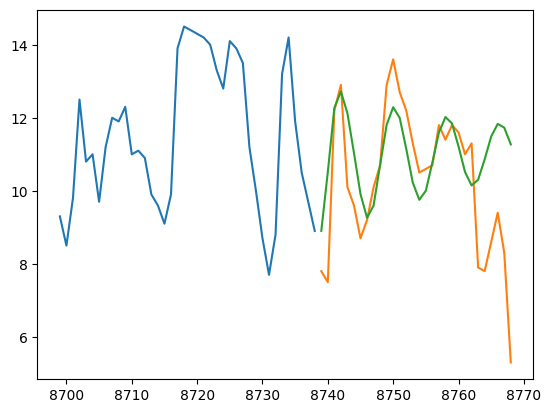

In [304]:
plt.plot(y_train[-40:])
plt.plot(y_test[:30])
plt.plot(res.forecast(30))

Le résultat reste le même, on peut voir que les premières prédictions sont proches des mesures mais suivent un pattern trop précis 


## SARIMAX model

On va mainteannt prendre en compte la saisonalité ainsi que les features

Il y a plusieurs saisonalités possibles : une annuel et une journalière. La recherche et l'entrainement d'un model avec la saisonalité annuel est trop long, on ne va donc pas la faire. Cependant on va essayer de prédire une année en entrainant un modèle sur une periodicité journalière. On va ensuite garder les hyper paramètres trouvés pour entrainer un modèle avec une autre régions et voir si les paramètres dépendent d'une région où son généraux.

In [305]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


2909 obesrvations correspond au nombre d'observation sur un ans de la BDD IledeFrance

In [306]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

y = IledeFrance['Température (°C)']
x = IledeFrance[col]

y_train = y[:2909]
x_train = x[:2909]
y_test = y[2909:3000]
x_test = x[2909:3000]


In [307]:
perform_adf_test(y_train)

ADF Statistic: -2.757684
p-value: 0.064577


non stationaire sur un ans

In [308]:
y_train_2 =  y_train.diff(1)
perform_adf_test(y_train_2.dropna())


ADF Statistic: -13.102835
p-value: 0.000000


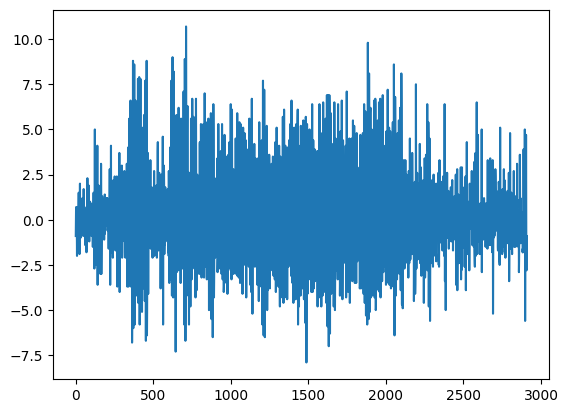

In [309]:
plt.plot(y_train_2)

Maintenant elle est stationaire, une seule différenciation est nécessaire 

Les cellules suivante permettent de faire la selection des meilleurs paramètres pour notre model SARIMAX

In [310]:
# import itertools



# p=d=q=range(0,2)

# pdq=list(itertools.product(p,d,q))
# seasonal_pdq=[(x[0],x[1],x[2],9) for x in list(itertools.product(p,d,q))]



In [311]:
# tab = []
# f = []
# s = []
# for pdq_params in pdq:
#     for seasonal_params in seasonal_pdq:
#         try:
#             model=SARIMAX(y_train,x_train,
#                           order=pdq_params,
#                           seasonal_order=seasonal_params
#                          )
#             result=model.fit()
#             # print("SARIMAX({}x{}12)-AIC:{}".format(pdq_params,
#             #                                        seasonal_params,
#             #                                        result.aicc
#             #                                       ))
#             print(pdq_params,seasonal_params,result.aic)
#             tab.append(result.aic)
#             f.append(pdq_params)
#             s.append(seasonal_params)
#         except:
#             continue




In [312]:
# min2 = tab.index(min(tab))
# pdq = f[min2]
# sais = s[min2]
# pdq,sais

In [313]:
# Pour saisonalité journalière
pdq = (1, 1, 1)
sais =(1, 0, 0, 9)

In [314]:
model=SARIMAX(y_train,x_train,
            order=pdq,
            seasonal_order=sais)
result=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14185D+00    |proj g|=  4.53717D+00

At iterate    5    f=  1.14041D+00    |proj g|=  6.93872D+00

At iterate   10    f=  1.13930D+00    |proj g|=  2.01860D+00

At iterate   15    f=  1.13585D+00    |proj g|=  7.62673D+00

At iterate   20    f=  1.13506D+00    |proj g|=  1.12093D-01

At iterate   25    f=  1.13447D+00    |proj g|=  2.91445D+00

At iterate   30    f=  1.11872D+00    |proj g|=  7.67576D+00

At iterate   35    f=  1.11560D+00    |proj g|=  2.21266D-01

At iterate   40    f=  1.10624D+00    |proj g|=  1.28319D+01

At iterate   45    f=  1.10499D+00    |proj g|=  6.12293D-01

At iterate   50    f=  1.10329D+00    |proj g|=  3.23989D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [315]:
predict=result.predict(start=len(y_train),
                    end=(len(y_train)+len(y_test)-1),
                    exog=x_test)


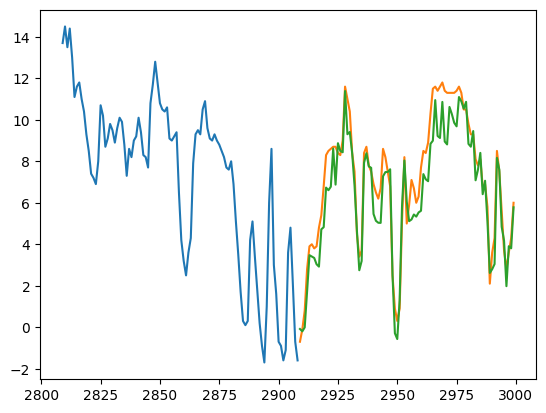

In [316]:
plt.plot(y_train[-100:])
plt.plot(y_test)
plt.plot(predict)

In [317]:
residuals = y_test - predict
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.1010817495181155


Prédiction à plus grande échelle

In [318]:
y_test = y[2909:]
x_test = x[2909:]

predict=result.predict(start=len(y_train),
                    end=(len(y_train)+len(y_test)-1),
                    exog=x_test)

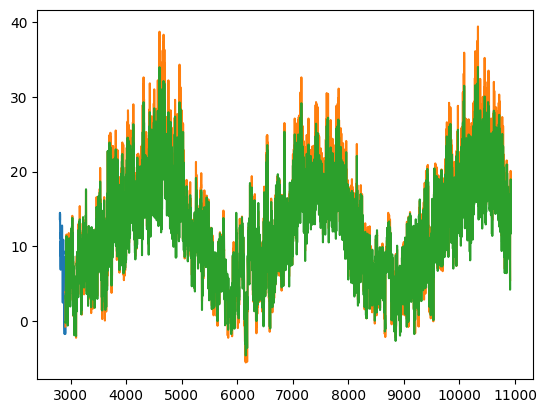

In [319]:
plt.plot(y_train[-100:])
plt.plot(y_test)
plt.plot(predict)

In [320]:
residuals = y_test - predict
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.5866431969993167


L'erreur reste très faible sur toute les données suivante c'est un modèle très (trop?) performant. Mais est ce qu'il est utile pour une autre région?

Utilisation d'un model identique sur une région complétement différente

In [321]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

y = Terresaustralesetantarctiquesfrançaises['Température (°C)']
x = Terresaustralesetantarctiquesfrançaises[col]

y_train = y[:2910]
x_train = x[:2910]
y_test = y[2910:3000]
x_test = x[2910:3000]

In [322]:
model=SARIMAX(y_train,x_train,
            order=pdq,
            seasonal_order=sais)
result=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94592D+00    |proj g|=  2.31733D+01


 This problem is unconstrained.



At iterate    5    f=  1.94256D+00    |proj g|=  8.24604D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      9     27      1     0     0   1.872D-01   1.942D+00
  F =   1.9420829042621934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [323]:
predict=result.predict(start=len(y_train),
                    end=(len(y_train)+len(y_test)-1),
                    exog=x_test)

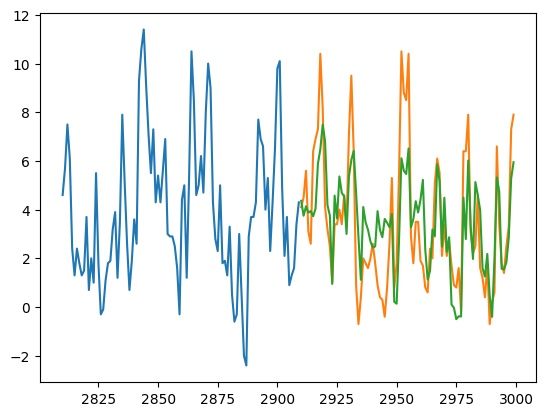

In [324]:
plt.plot(y_train[-100:])
plt.plot(y_test)
plt.plot(predict)

In [325]:
residuals = y_test - predict
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.8672168079357203


Les prédicitions sont loin d'être mauvaises mais ne sont pas aussi précises que pour le modèle précédent.

## DEEP

### RNN sans features

In [326]:
from sklearn.preprocessing import MinMaxScaler

In [327]:
Terresaustralesetantarctiquesfrançaises.set_index('Date', inplace = True)


In [645]:
T = 10
HORIZON = 1

In [646]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']
valid_start_dt = '2021-07-01 00:00:00'
test_start_dt = '2022-01-01 00:00:00' 
train = Terresaustralesetantarctiquesfrançaises.copy()[Terresaustralesetantarctiquesfrançaises.index < valid_start_dt][['Température (°C)']]

scaler = MinMaxScaler()
train['Température (°C)'] = scaler.fit_transform(train)
# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['Température (°C)'].shift(-1)

for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['Température (°C)'].shift(T-t)
y_col = 'y_t+1'
X_cols = [  'temp_t-9',
            'temp_t-8',
            'temp_t-7',
            'temp_t-6',
            'temp_t-5',
             'temp_t-4',
             'temp_t-3',
             'temp_t-2',
             'temp_t-1',
             'temp_t']
train_shifted.columns = ['temp_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,temp_original,y_t+1,temp_t-9,temp_t-8,temp_t-7,temp_t-6,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
Date,,,,,,,,,,,,
2019-01-03 22:00:00,0.339844,0.484375,0.519531,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844
2019-01-04 04:00:00,0.484375,0.636719,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375
2019-01-04 10:00:00,0.636719,0.464844,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719
2019-01-04 16:00:00,0.464844,0.472656,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719,0.464844
2019-01-04 22:00:00,0.472656,0.511719,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719,0.464844,0.472656


In [647]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [648]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [649]:
train_shifted.head(3)

,temp_original,y_t+1,temp_t-9,temp_t-8,temp_t-7,temp_t-6,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
Date,,,,,,,,,,,,
2019-01-03 22:00:00,0.339844,0.484375,0.519531,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844
2019-01-04 04:00:00,0.484375,0.636719,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375
2019-01-04 10:00:00,0.636719,0.464844,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719


In [650]:
import datetime as dt

# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = Terresaustralesetantarctiquesfrançaises.copy()[(Terresaustralesetantarctiquesfrançaises.index >=look_back_dt) & (Terresaustralesetantarctiquesfrançaises.index < test_start_dt)][['Température (°C)']]

# 2. Scale the series using the transformer fitted on the training set:
valid['Température (°C)'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['Température (°C)'].shift(-1)
for t in range(1, T+1):
    valid_shifted['temp_t-'+str(T-t)] = valid_shifted['Température (°C)'].shift(T-t)
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,Température (°C),y+1,temp_t-9,temp_t-8,temp_t-7,temp_t-6,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t-0
Date,,,,,,,,,,,,
2021-07-02 23:00:00,0.527344,0.484375,0.328125,0.304688,0.265625,0.324219,0.253906,0.234375,0.324219,0.378906,0.445313,0.527344
2021-07-03 05:00:00,0.484375,0.363281,0.304688,0.265625,0.324219,0.253906,0.234375,0.324219,0.378906,0.445313,0.527344,0.484375
2021-07-03 11:00:00,0.363281,0.250000,0.265625,0.324219,0.253906,0.234375,0.324219,0.378906,0.445313,0.527344,0.484375,0.363281


In [651]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['temp_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [652]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [653]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,GRU ,RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

In [654]:
model=Sequential()

In [655]:
LATENT_DIM = 100 # number of units in the RNN layer
BATCH_SIZE = 64 # number of samples per mini-batch
EPOCHS = 200 # maximum number of times the training algorithm will cycle through all samples


In [656]:


model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dropout(0.2))
model.add(Dense(HORIZON))



In [657]:
model.compile(optimizer='RMSprop', loss='mse')

In [658]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [659]:

model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_45 (GRU)                (None, 100)               30900     
                                                                 
 dropout_35 (Dropout)        (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [660]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/200


2022-11-03 14:06:37.647270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 14:06:37.890564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 14:06:38.146255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.0196

2022-11-03 14:06:40.156695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 14:06:40.215630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 3s 46ms/step - loss: 0.0196 - val_loss: 0.0127
Epoch 2/200
47/47 [==============================] - 1s 17ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 3/200
47/47 [==============================] - 1s 15ms/step - loss: 0.0118 - val_loss: 0.0105
Epoch 4/200
47/47 [==============================] - 1s 17ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 5/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 6/200
47/47 [==============================] - 1s 17ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 7/200
47/47 [==============================] - 1s 15ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 8/200
47/47 [==============================] - 1s 16ms/step - loss: 0.0100 - val_loss: 0.0090
Epoch 9/200
47/47 [==============================] - 1s 15ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 10/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 11/20

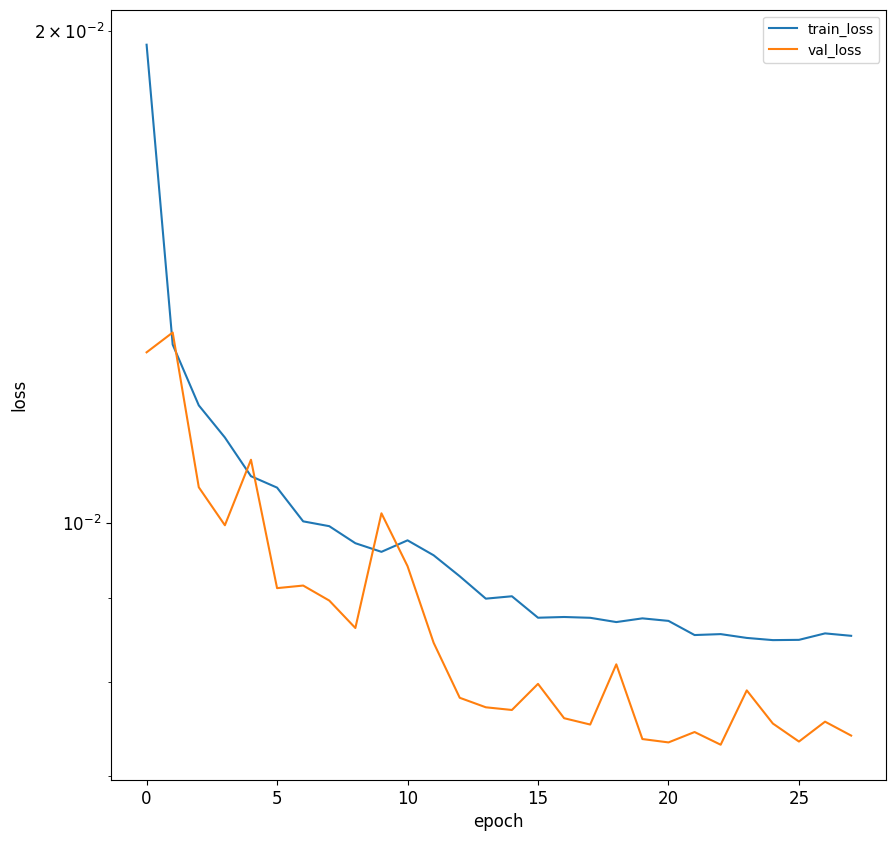

In [661]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()


In [662]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = Terresaustralesetantarctiquesfrançaises.copy()[test_start_dt:][['Température (°C)']]

# 2. Scale the data
test['Température (°C)'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['Température (°C)'].shift(-1)
for t in range(1, T+1):
    test_shifted['temp_t-'+str(T-t)] = test_shifted['Température (°C)'].shift(T-t)

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['temp_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)



In [663]:
predictions = model.predict(X_test)
predictions

 1/33 [..............................] - ETA: 8s

2022-11-03 14:06:59.860388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 14:06:59.900078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 9ms/step


array([[0.30489644],
       [0.40974054],
       [0.38864607],
       ...,
       [0.30513442],
       [0.28120196],
       [0.239918  ]], dtype=float32)

In [664]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2022-01-03 16:00:00,t+1,2.605349,3.0
1,2022-01-03 22:00:00,t+1,5.289358,4.6
2,2022-01-04 04:00:00,t+1,4.749339,7.6
3,2022-01-04 10:00:00,t+1,5.339763,6.1
4,2022-01-04 16:00:00,t+1,5.646207,3.3


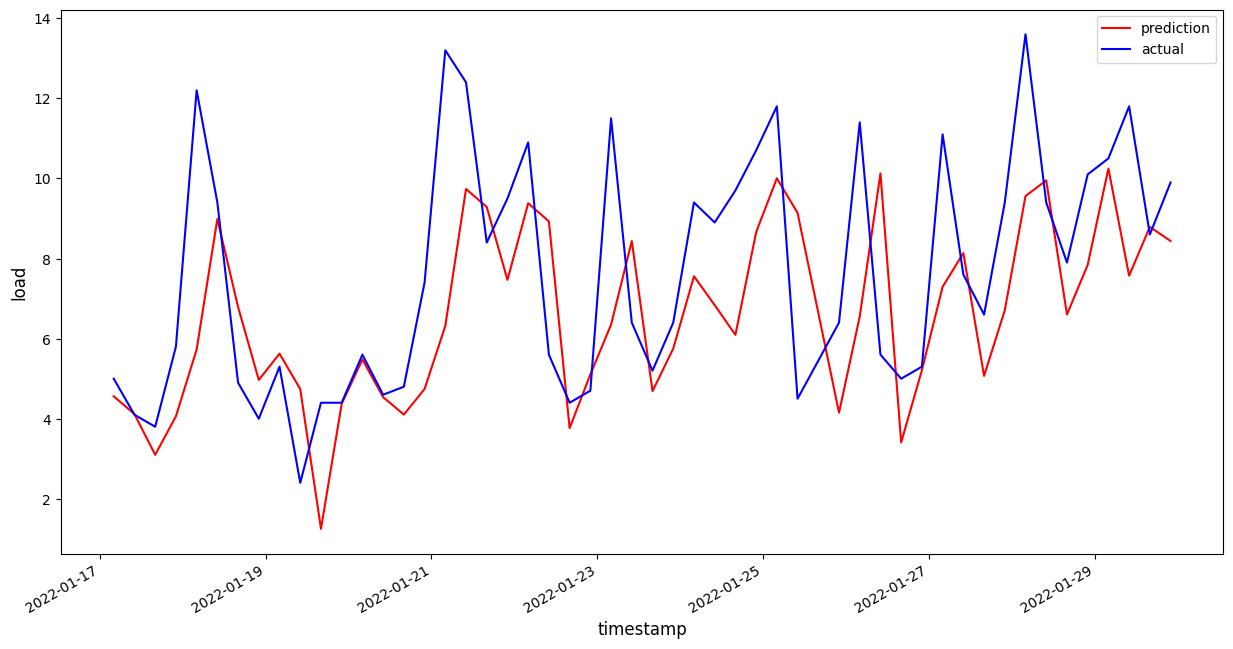

In [665]:
eval_df[eval_df.timestamp<'2022-01-30'][eval_df.timestamp>'2022-01-17'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [666]:
residuals = eval_df['actual'] - eval_df['prediction']
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.2407654136336843


On voit que les prédiction sont décalée d'une période dans le temps 

### Cas d'étude, les prédictions sont elles susceptibles de prévoir des événements météorologiques important tel que des sécheresses ?

Nous essaierons ici de prédire pour une région donnée, extensible à toutes nos régions, les températures ainsi que le taux de précipitations dans les 3 dernières heures. Si nous observons à la fois de fortes températures et un niveau de précipitation faible, alors nous pourrons estimer qu'un risque de sécheresse est élevé. L'objectif est d'améliorer la confiance que nous pouvons accorder à nos prédictions si plusieurs prédictions sur différentes données nous orientent tous vers la même conclusion car nous estimons que la température seule ne suffirait pas a établir une alerte. Nous utiliserons ici SARIMAX et notre région de test sera la Normandie.

In [688]:
IledeFrance

,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,
2019-01-01 01:00:00,7.9,103630.0,2.6,84.0,102510.0,5.1,0.0
2019-01-01 04:00:00,7.0,103610.0,2.3,91.0,102480.0,4.1,-0.1
2019-01-01 07:00:00,7.1,103500.0,2.0,89.0,102380.0,3.9,0.0
2019-01-01 10:00:00,7.8,103510.0,2.3,84.0,102390.0,5.0,0.0
2019-01-01 13:00:00,8.1,103470.0,3.4,77.0,102350.0,7.8,0.0
...,...,...,...,...,...,...,...
2022-10-01 11:00:00,16.5,101160.0,4.8,87.0,100100.0,9.1,0.0
2022-10-01 14:00:00,20.1,101310.0,6.0,64.0,100260.0,12.7,0.0
2022-10-01 17:00:00,19.8,101460.0,5.4,57.0,100410.0,13.0,-0.1


In [689]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période']

y_temp = IledeFrance['Température (°C)']
y_pluie= IledeFrance['Précipitations dans les 3 dernières heures']
x = IledeFrance[col]

y_temp_train = y_temp[:2909]
y_pluie_train = y_pluie[:2909]
x_train = x[:2909]
y_temp_test = y_temp[2909:3000]
y_pluie_test = y_pluie[2909:3000]
x_test = x[2909:3000]

y_pluie_test

Date
2020-01-01 04:00:00    0.0
2020-01-01 07:00:00    0.0
2020-01-01 10:00:00    0.0
2020-01-01 13:00:00    0.0
2020-01-01 16:00:00    0.0
                      ... 
2020-01-11 22:00:00    0.0
2020-01-12 01:00:00    0.0
2020-01-12 04:00:00    0.0
2020-01-12 07:00:00    0.0
2020-01-12 10:00:00    0.0
Name: Précipitations dans les 3 dernières heures, Length: 91, dtype: float64

In [690]:
perform_adf_test(y_temp_train)
perform_adf_test(y_pluie_train)

ADF Statistic: -2.757684
p-value: 0.064577
ADF Statistic: -8.980038
p-value: 0.000000


In [691]:
model_pluie=SARIMAX(y_pluie_train,x_train,
            order=pdq,
            seasonal_order=sais)
result_pluie=model_pluie.fit()
predict_pluie=result_pluie.predict(start=len(y_pluie_train),
                    end=(len(y_pluie_train)+len(y_pluie_test)-1),
                    exog=x_test)

plot_ys(y_pluie_train[-100:], y_pluie_test, predict_pluie, labels=["y_train", "y_test", "y_pred"]);
plot_ys(y_pluie_test)
plot_ys(predict_pluie)
residuals = y_pluie_test - predict_pluie
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39866D+00    |proj g|=  3.06574D+00

At iterate    5    f=  1.39661D+00    |proj g|=  2.13062D+00

At iterate   10    f=  1.39651D+00    |proj g|=  2.29084D+00

At iterate   15    f=  1.39519D+00    |proj g|=  6.37806D-01

At iterate   20    f=  1.39500D+00    |proj g|=  2.80889D-01

At iterate   25    f=  1.39479D+00    |proj g|=  4.02319D+00

At iterate   30    f=  1.39278D+00    |proj g|=  6.32371D-01

At iterate   35    f=  1.39276D+00    |proj g|=  5.44291D-01

At iterate   40    f=  1.39201D+00    |proj g|=  3.03599D+00

At iterate   45    f=  1.39174D+00    |proj g|=  9.45637D-01

At iterate   50    f=  1.39083D+00    |proj g|=  4.17247D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

TypeError: Found series with inconsistent index types, please make sure all series have the same index type.

Root Mean Squared Error: 2.077289688473807


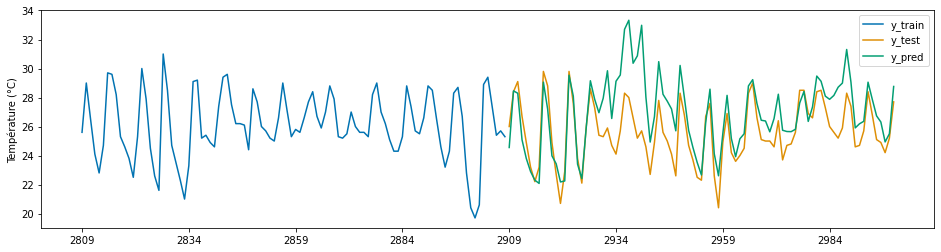

In [ ]:
model_temp=SARIMAX(y_temp_train,x_train,
            order=pdq,
            seasonal_order=sais)
result_temp=model_temp.fit()
predict_temp=result_temp.predict(start=len(y_temp_train),
                    end=(len(y_temp_train)+len(y_temp_test)-1),
                    exog=x_test)

plot_ys(y_temp_train[-100:], y_temp_test, predict_temp, labels=["y_train", "y_test", "y_pred"]);

residuals = y_temp_test - predict_temp
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

## 2

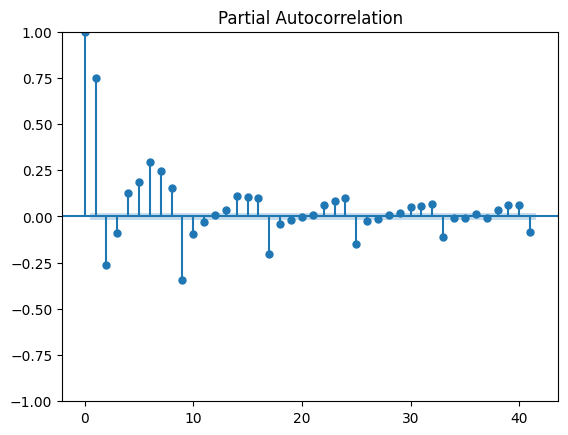

In [712]:
pacf_plot = plot_pacf(Corse['Humidité'])

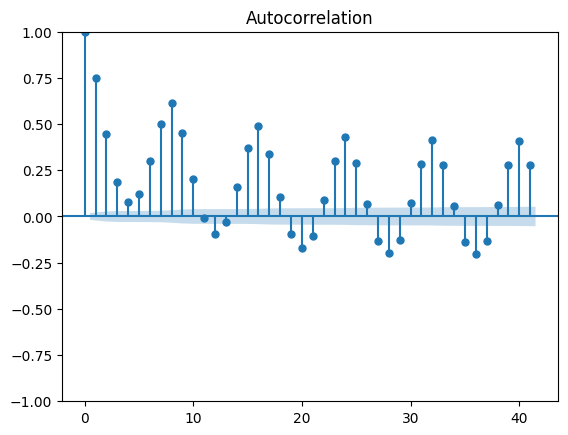

In [713]:
pacf_plot = plot_acf(Corse['Humidité'])

In [756]:

y_temp = Corse['Température (°C)']
y_raf= Corse['Humidité']

y_temp_train = y_temp[:2850]
y_raf_train = y_raf[:2850]
y_temp_test = y_temp[2850:3000]
y_raf_test = y_raf[2850:3000]




In [757]:
mod_ARMA_raf = ARIMA(y_raf_train, order=(10,0,10))
res = mod_ARMA_raf.fit()

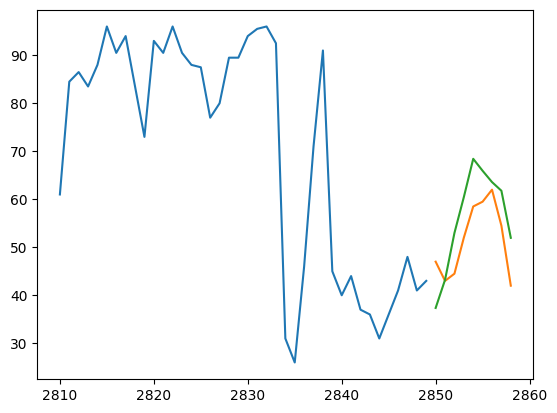

In [758]:
plt.plot(y_raf_train[-40:])
plt.plot(y_raf_test[:9])
plt.plot(res.forecast(9))

In [759]:
mod_SARIMAX_temp = SARIMAX(y_temp_train,y_raf_train, order=(8,0,10),seasonal_order=(0,0,0,0))
res2 = mod_SARIMAX_temp.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37290D+00    |proj g|=  2.33826D+00


 This problem is unconstrained.



At iterate    5    f=  1.94815D+00    |proj g|=  3.87913D-01

At iterate   10    f=  1.56872D+00    |proj g|=  7.51382D-01

At iterate   15    f=  1.50177D+00    |proj g|=  3.07164D-01

At iterate   20    f=  1.49081D+00    |proj g|=  6.92924D-02

At iterate   25    f=  1.48830D+00    |proj g|=  2.97816D-02

At iterate   30    f=  1.48530D+00    |proj g|=  3.31653D-02

At iterate   35    f=  1.48096D+00    |proj g|=  5.64652D-02

At iterate   40    f=  1.47949D+00    |proj g|=  6.25743D-02

At iterate   45    f=  1.47583D+00    |proj g|=  6.23530D-02

At iterate   50    f=  1.47342D+00    |proj g|=  9.87907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [760]:
predict=res2.predict(start=len(y_temp_train),
                    end=(len(y_temp_train)+len(res.forecast(9))-1),
                    exog=res.forecast(9))


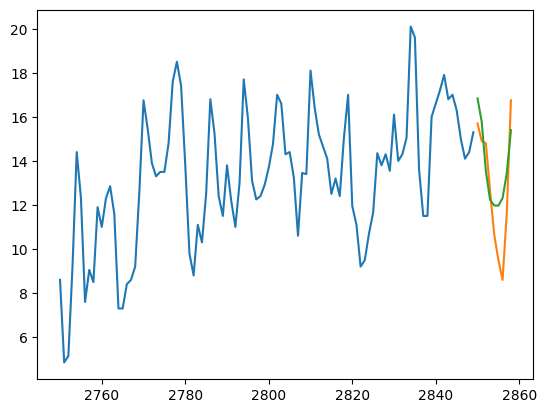

In [762]:
plt.plot(y_temp_train[-100:])
plt.plot(y_temp_test[:9])
plt.plot(predict)

# Conclusion
Avec cette base de données on ne peut prédire correctement des données futur car nos features sont des observations, il faudrait alors anticiper ces features. On peut essayer de prédire ces features mais on sait que les données météo sont soumises à l'effet papillon et donc très aléatoire. Cependant à cours terme il est possible d'avoir quelques estimations sur ces features et donc prédire la température de manière imprécise car se ne sont que des estimations et nous sommes limités à un proche futur. Il y a certain cas où on pourrait prédire plus loin. Par exemple lorsqu'une région va être sous un anti cyclone (phénomène que on prédit plutôt bien ), on sera au courant qu'il n'y aura pas de vent, pas de pluie, pression constante, etc... on pourra donc prédire un plus grand horizon les températures.

D'autre part on observe que nos features sont très utile pour la prédiction de la température car les modèles utilisant les features sont beaucoup plus précis que les autres (cf ARMA vs SARIMAX).